# Test the influence of the number of bins on the poisson parameters

## Data input

#### Imports

In [1]:
# Processing
from __future__ import division, print_function
import pandas as pd
import numpy as np
from copy import deepcopy
from datetime import timedelta
import calendar
from scipy.optimize import curve_fit
from scipy.misc import factorial

# Plotting
import matplotlib.pyplot as plt
plt.style.use = 'default' 
%matplotlib inline
import mpld3
from mpld3 import plugins, utils
mpld3.enable_notebook()

#### Data - CSV

In [2]:
files = ["../Data_Acetate/acetateAlarms.csv","../Data_Acetate/acetateAlarmsTr.csv"]

def DataRange(data):
    return [min(data['Timestamp']) - timedelta(seconds=2) , max(data['Timestamp']) + timedelta(seconds=2)]
    
def Data(files,systems=None):
    ''' Read the input data (one or more files, with the possibility to give the data from each file a (different) label). 
       Remove irrelevant entries (alarms being acknowledged or going off / alarms that are not really errors).
       Group the data by ID (ID's of which only one message was recorded, are left out).
       Add to each entry a field holding the time between this message and the previous one (in hours).
    '''
    # Read CSV data
    dfs = [pd.read_csv(f,encoding="utf-8-sig",parse_dates=['Timestamp']) for f in files]
    if systems and len(systems) == len(files):
        for i,x in enumerate(systems):
            dfs[i]['System'] = x
    df = pd.concat(dfs)

    # Remove irrelevant data
    if 'State' in df.columns:            # upcoming alarms (no OFF/ACK)
        df = df[df['State']==1]                                         
        del df['State']
    if 'Class' in df.columns:           # error messages (no System/Tolerance)
        df = df[df['Class']=='Error']
        del df['Class']  
    df.sort_values(by='Timestamp',inplace=True)    
    
    # Grouped data (by ID)
    dfs = {x: df[df['Id']==x].copy() for x in set(list(df['Id'])) if len(df[df['Id']==x]) > 1}    # get one dataframe per component ID
    
    # Add time interval data
    span = DataRange(df)
    keys = sorted(list(dfs.keys()))
    for key in keys:
        dfs_prior = dfs[key][:2].copy()                             # add entry on first and last timestamp
        dfs_prior['Timestamp'] = span
        dfs[key] = pd.concat([dfs[key],dfs_prior])
        dfs[key].sort_values('Timestamp',inplace=True)                              # sort on timestamp
        dfs[key]['Delta'] = dfs[key]['Timestamp'] - dfs[key]['Timestamp'].shift(1)  # calculate time between
        dfs[key] = dfs[key][dfs[key]['Delta'].notnull()]
        dfs[key]['Delta'] = dfs[key]['Delta'].map(lambda x: x.days*24 + x.seconds//3600 + int((x.seconds%3600)/36)/100)
        #dfs[key]['Delta'] = dfs[key]['Delta'].map(lambda x: x.days*24*60 + x.seconds//60)
        dfs[key].index = range(len(dfs[key]))
    return dfs, keys, span

dfs, dfs_ids, dfs_range = Data(files,["Acetate","Tracing"])
dfs[list(dfs.keys())[0]].head()

/usr/local/lib/python2.7/dist-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/usr/local/lib/python2.7/dist-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


Timestamp                                            Message  \
0 2015-12-04 05:36:17  XS-TR34-TP20-01-LDT: LEIDINGTEMPERATUUR TRACIN...   
1 2015-12-04 05:36:47  XS-TR34-TP20-01-LDT: LEIDINGTEMPERATUUR TRACIN...   
2 2015-12-04 07:02:54  XS-TR34-TP20-01-LDT: LEIDINGTEMPERATUUR TRACIN...   
3 2015-12-15 04:10:25  XS-TR34-TP20-01-LDT: LEIDINGTEMPERATUUR TRACIN...   
4 2016-03-18 14:39:22  XS-TR34-TP20-01-LDT: LEIDINGTEMPERATUUR TRACIN...   

                    Id   Type            Group   System    Delta  
0  XS-TR34-TP20-01-LDT  Alarm  XS-TR34-TP20-01  Tracing   418.98  
1  XS-TR34-TP20-01-LDT  Alarm  XS-TR34-TP20-01  Tracing     0.00  
2  XS-TR34-TP20-01-LDT  Alarm  XS-TR34-TP20-01  Tracing     1.43  
3  XS-TR34-TP20-01-LDT  Alarm  XS-TR34-TP20-01  Tracing   261.12  
4  XS-TR34-TP20-01-LDT  Alarm  XS-TR34-TP20-01  Tracing  2266.48

#### Data - Count

In [3]:
def NumberOfOccurrences(data):
    ''' Count for each ID the number of occurrences. 
    '''
    return {x: data[x]['Message'].count() for x in data.keys()}    

def NumberOfMessages(data, dataRange):
    ''' Count for each ID the number of times each message occured per date. 
    ''' 
    ds = deepcopy(data)
    day_f = dataRange[0].date().replace(day=1)
    day_l = dataRange[1].date().replace(day=calendar.monthrange(dataRange[0].date().year, dataRange[0].date().month)[1])
    days = [day_f + timedelta(days=x) for x in range((day_l-day_f).days+1)]
    for key in list(ds.keys()):
        ds[key]['Timestamp'] = ds[key]['Timestamp'].map(lambda x: x.date())
        ds[key]['Count'] = ds[key]['Message'].map(lambda x: 1)
        ds[key] = ds[key][['Timestamp','Message','Count']]
        ds[key] = pd.pivot_table(ds[key],index=["Timestamp"],columns=["Message"],aggfunc=[np.sum])
        ds[key].columns = ds[key].columns.droplevel([0,1])        # remove irrelevant top levels
        ds[key].replace(np.NaN,0,inplace=True)                    # convert NaN to 0
        for day in days:                                          # fill gaps in time data
            if day not in ds[key].index:
                ds[key].loc[day] = [0]*len(ds[key].columns)
        ds[key].sort_index(inplace=True)
    return ds

dfs_noo = NumberOfOccurrences(dfs)
dfs_nom = NumberOfMessages(dfs,dfs_range)

## Tool

#### Poisson parameters

In [4]:
def Poisson(k, lamb):
    ''' Poisson distribution. 
    '''
    return (lamb**k/factorial(k)) * np.exp(-lamb)

def PoissonParameters(data,bins=False):
    ''' Fit a poisson distribution on the histogram of the data per ID and return the resulting poisson parameters.
    '''
    params = dict()
    for key in list(data.keys()):
        deltas = list(data[key]['Delta'])
        if not bins:
            bins = int(np.max(deltas)*60)
        entries, bin_edges = np.histogram(deltas,bins)  
        bin_middles = 0.5*(bin_edges[1:] + bin_edges[:-1])  
        parameters, _ = curve_fit(Poisson, bin_middles, entries)
        params[key] = int(parameters[0]*1000)/1000  
    return params

#### Tool

In [5]:
def Month(date):
    return '{}-{:02}'.format(date.year,date.month)

def Overview(label,data):
    d = deepcopy(data)
    #d['Total'] = d.sum(axis=1)
    #fig, ax = plt.subplots(subplot_kw=dict(axisbg='#EEEEEE'),figsize=(12, 6))
    fig, ax = plt.subplots(figsize=(12, 6))
    #ax.grid(color='white', linestyle='solid')
    ax.set_title(label[0])
    #ax.set_title('{} (#={},pp={})'.format(label[0],label[2],label[1]))
    #ax.set_xlabel("Date")
    ax.set_ylabel("Number of occurrences")
    d.plot(ax=ax)                                    
    #d.plot.bar(ax=ax,stacked=True)                                    
    plt.xticks(rotation='vertical')
    plt.savefig('tests/{}.png'.format(label[0]))
    #plt.show()
    return

def DetailedView(label, data):
    fig, ax = plt.subplots(subplot_kw=dict(axisbg='#EEEEEE'),figsize=(12, 6))
    ax.set_title('{} ({} {})'.format(label[0],calendar.month_name[int(label[1].split('-')[1])],label[1].split('-')[0]))
    #ax.set_xlabel("Date")
    ax.set_ylabel("Number of occurrences")
    data.plot.bar(ax=ax, stacked=True)                      # plot per month
    if plt.ylim()[1] < 1:                                   # set axis for empty plots
        plt.ylim(0,1)
    ax.legend().set_visible(False)                          # hide legend
    plt.show()   
    return 

def BarPlot(label,data):
    ''' Show (stacked) bar plot of the number of occurences (of the different messages) of a component ID. 
    '''
    Overview(label,data)
    return
    gr = data.groupby(data.index.map(Month))                     # group by month
    data_gr = {x:gr.get_group(x).copy() for x in gr.groups}
    for i,key in enumerate(list(data_gr.keys())):
        DetailedView([label[0],key],data_gr[key])
    return

def ScatterPlot(data_x,data_y,data_l,bins):
    ''' Show scatter plot with interactive artists. (hover = show label , click = show detailed view)
    '''
    fig, ax = plt.subplots(subplot_kw=dict(axisbg='#EEEEEE'),figsize=(12,8))
    ax.grid(color='white', linestyle='solid')
    ax.set_title("Component ID's")
    ax.set_xlabel("Poisson parameters")
    ax.set_ylabel("Number of occurrences")
    scatter = ax.scatter(data_x,data_y)
    tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=data_l)  
    mpld3.plugins.connect(fig, tooltip)
    #plt.savefig('tests/scatter_{}.png'.format(bins))
    #mpld3.show()
    return fig

#### Run it!

In [6]:
# SELECTION
select_bins = [1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000]
select_x, select_y = [4,3]
select_ids  = ['PT-300-7-005','FT-250-4-AL-INIT','T420-2-ET1','T250-5-EL1',
               'XV-528-005','T420-3-EP1','PDIT-420-03-003','PTWW-300-6-7-001']
select_colors = ['red','yellow','orange','cyan','purple','grey','green','magenta']

/usr/local/lib/python2.7/dist-packages/scipy/optimize/minpack.py:690: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


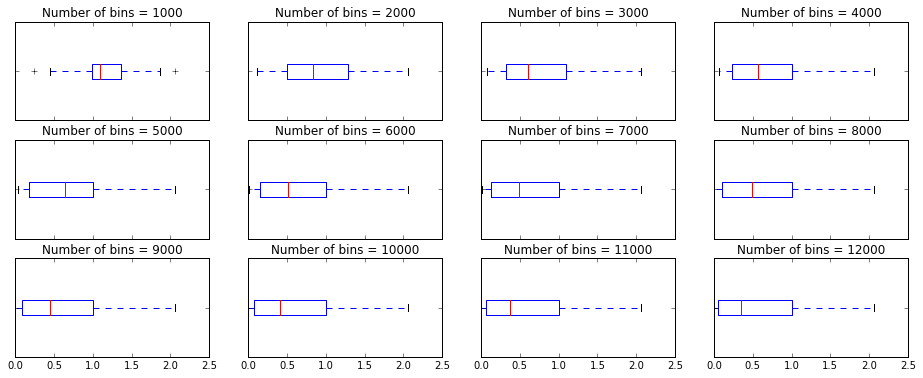

In [7]:
import itertools
dfs_pdp_test = list()
mpld3.disable_notebook()

fig, ax = plt.subplots(select_y, select_x, sharex="col", sharey="row", figsize=(select_x*4, select_y*2))
for x,(i,j) in enumerate(itertools.product(range(select_y),range(select_x))):
    if x >= len(select_bins):
        break
    dfs_pdp_test.append(PoissonParameters(dfs,bins=select_bins[x]))
    ax[i,j].set_title("Number of bins = {}".format(select_bins[x]))
    ax[i,j].boxplot(list(dfs_pdp_test[x].values()), 0, 'r', 0)
    ax[i,j].yaxis.set_major_formatter(plt.NullFormatter())

#plt.savefig('tests/A3/a3_box.png')
plt.show()
    
mpld3.enable_notebook()


Note: if you're in the IPython notebook, mpld3.show() is not the best command
      to use. Consider using mpld3.display(), or mpld3.enable_notebook().
      See more information at http://mpld3.github.io/quickstart.html.

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8889/    [Ctrl-C to exit]


127.0.0.1 - - [01/Aug/2016 15:11:07] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [01/Aug/2016 15:11:07] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [01/Aug/2016 15:11:07] "GET /mpld3.js HTTP/1.1" 200 -
127.0.0.1 - - [01/Aug/2016 15:11:08] code 404, message Not Found
127.0.0.1 - - [01/Aug/2016 15:11:08] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [01/Aug/2016 15:11:09] code 404, message Not Found
127.0.0.1 - - [01/Aug/2016 15:11:09] "GET /favicon.ico HTTP/1.1" 404 -



stopping Server...


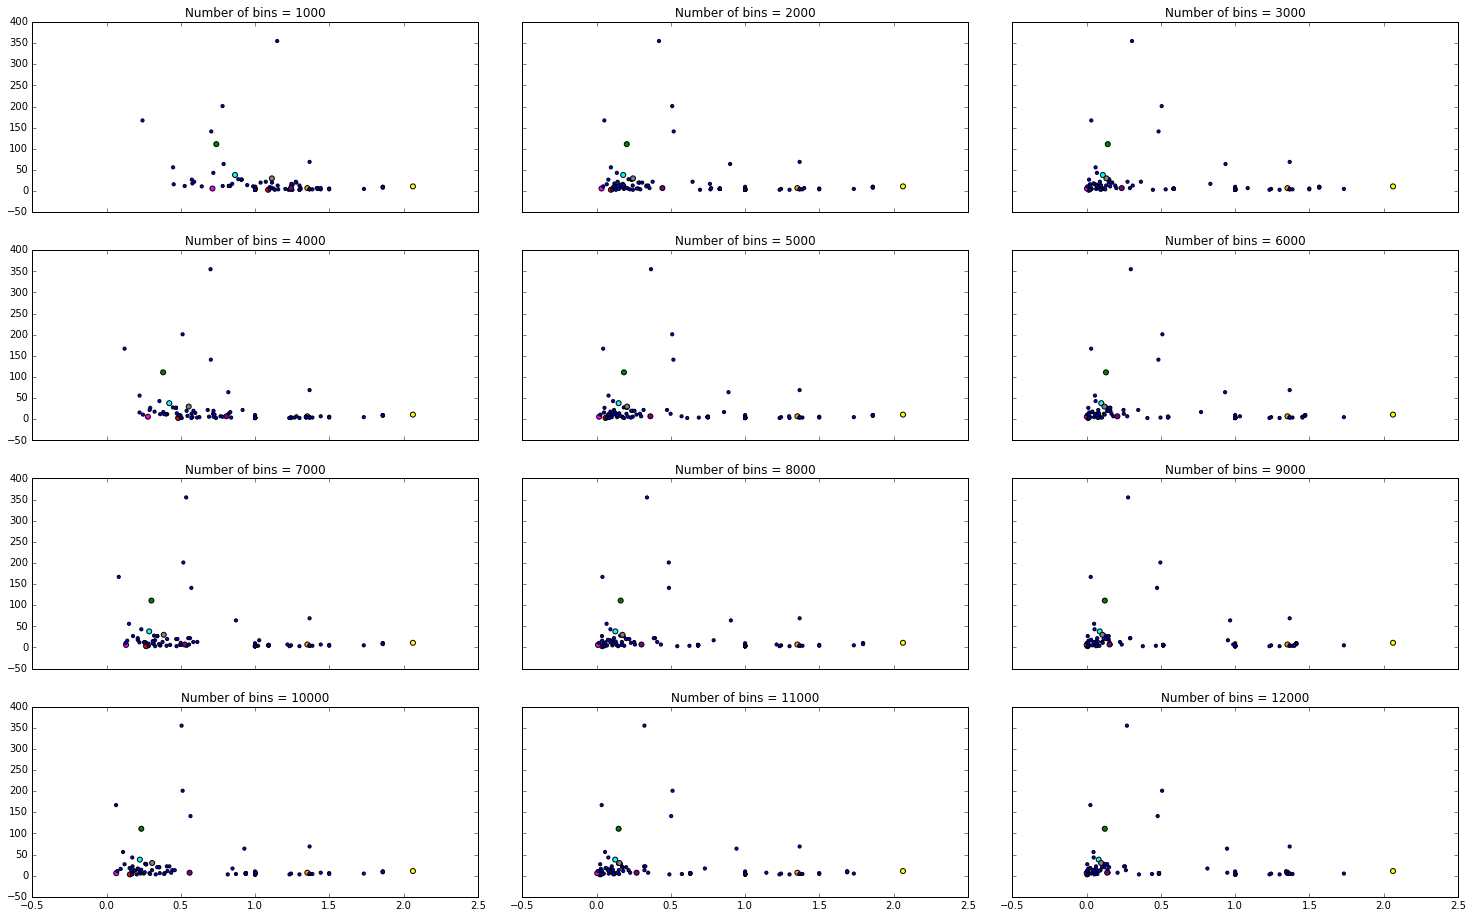

In [ ]:
# PLOT
colors = [select_colors[select_ids.index(x)] if x in select_ids else 'b' for x in dfs_ids]   
size = [(10 if x=='b' else 25) for x in colors]
reshape_bins = deepcopy(select_bins)
reshape_bins.extend(['']*((select_x*select_y)-len(reshape_bins)))
labels = np.reshape(reshape_bins,(select_x,select_y))

fig, ax = plt.subplots(select_x, select_y, sharex="col", sharey="row", figsize=(select_x*5.5, select_y*4.5))
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95,hspace=0.2, wspace=0.1)

for x,(j,i) in enumerate(itertools.product(range(select_y),range(select_x))):
    data_bar = [[y , dfs_pdp_test[x][y] , dfs_noo[y]] for y in dfs_ids]
    data_scatter = list(map(list, zip(*data_bar)))
    ax[i,j].set_title("Number of bins = {}".format(labels[i][j]))
    points = ax[i,j].scatter(data_scatter[1],data_scatter[2],c=colors,s=size)
    
plugins.connect(fig, plugins.LinkedBrush(points))
mpld3.show()

In [ ]:
data_bar = [[x , dfs_pdp_test[0][x] , dfs_noo[x]] for x in dfs_ids]
data_sca = list(map(list, zip(*data_bar)))
ScatterPlot(data_sca[1],data_sca[2],data_sca[0],select_bins[0])
mpld3.show()


Note: if you're in the IPython notebook, mpld3.show() is not the best command
      to use. Consider using mpld3.display(), or mpld3.enable_notebook().
      See more information at http://mpld3.github.io/quickstart.html.

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8889/    [Ctrl-C to exit]


127.0.0.1 - - [01/Aug/2016 15:13:58] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [01/Aug/2016 15:13:58] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [01/Aug/2016 15:13:58] "GET /mpld3.js HTTP/1.1" 200 -


In [ ]:
def ScatterPlot(d_sca):
    ''' Show scatter plot with interactive artists. (hover = show label , click = show detailed view)
    '''
    d_x, d_y, d_l = list(map(list, zip(*d_sca)))
    fig, ax = plt.subplots(subplot_kw=dict(axisbg='#EEEEEE'),figsize=(12,8))
    ax.grid(color='white', linestyle='solid')
    ax.set_title("Component ID's")
    ax.set_xlabel("Poisson parameters")
    ax.set_ylabel("Number of occurrences")
    scatter = ax.scatter(d_x,d_y)
    tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=d_l)  
    mpld3.plugins.connect(fig, tooltip)
    return


data_sca = [[data_pdp[x], data_noo[x], x] for x in data_pdp]
ScatterPlot(data_sca)